# Librairies

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import warnings
import pickle
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn import metrics

# Lecture data clean

In [2]:
data = pd.read_csv("data_clean.csv")

# Baseline : dummy classifier

In [66]:
x_train, x_test, y_train, y_test = train_test_split(data[data.columns.difference(['TARGET'])], data['TARGET'],
                                                         stratify = data['TARGET'],random_state = 42)

In [4]:
pickle.dump(x_train,open("/mnt/c/Users/hager/OneDrive/Documents/projet_7/Openclassrooms_p7/X_train", "wb"))
pickle.dump(x_test,open("/mnt/c/Users/hager/OneDrive/Documents/projet_7/Openclassrooms_p7/X_test", "wb"))

In [67]:
x_train = x_train.drop(columns = "SK_ID_CURR")
x_test = x_test.drop(columns = "SK_ID_CURR")

In [7]:
dum = DummyClassifier(strategy ='most_frequent')

# Entraînement
dum.fit(x_train, y_train)

DummyClassifier(strategy='most_frequent')

In [8]:
# Prédiction sur le jeu de test
Y_pred_dum = dum.predict(x_test)

# Evaluate
print("ROC AUC Score : {}".format(metrics.roc_auc_score(y_test, Y_pred_dum)))
print("Confusion Matrix : \n {}".format(metrics.confusion_matrix(y_test, Y_pred_dum)))

ROC AUC Score : 0.5
Confusion Matrix : 
 [[70671     0]
 [ 6206     0]]


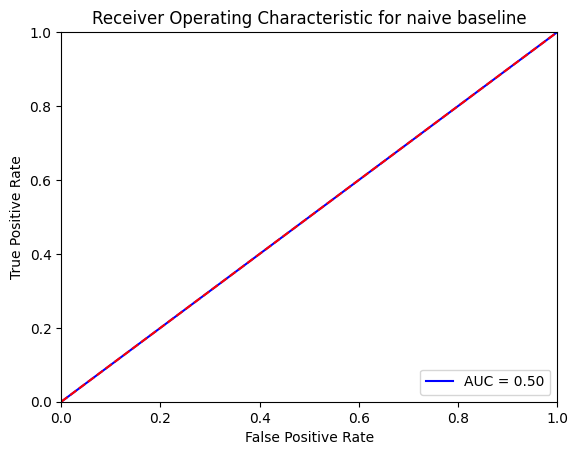

In [9]:
fpr, tpr, threshold = metrics.roc_curve(y_test, Y_pred_dum)
roc_auc = metrics.auc(fpr, tpr)

#### Plot Roc Curve
plt.title('Receiver Operating Characteristic for naive baseline')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Random Forest classifier

In [10]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('mdl', RandomForestClassifier(n_estimators = 100))
    ])

params = dict(mdl__max_depth=[6,10],
              mdl__min_samples_split=[2, 3, 4],
              mdl__max_features=['sqrt', 'log2'])
    
def custom_metric(y_test, y_pred):
    _, fp, fn, _ = confusion_matrix(y_test, y_pred).ravel()
    score = 10*fn + fp
    return -score

custom_metric = make_scorer(custom_metric)
score = "roc_auc"

grid = GridSearchCV(model, params, cv=5, scoring=score, n_jobs=1, verbose=2)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END mdl__max_depth=6, mdl__max_features=sqrt, mdl__min_samples_split=2; total time=  44.5s
[CV] END mdl__max_depth=6, mdl__max_features=sqrt, mdl__min_samples_split=2; total time=  41.9s
[CV] END mdl__max_depth=6, mdl__max_features=sqrt, mdl__min_samples_split=2; total time=  41.5s
[CV] END mdl__max_depth=6, mdl__max_features=sqrt, mdl__min_samples_split=2; total time=  41.2s
[CV] END mdl__max_depth=6, mdl__max_features=sqrt, mdl__min_samples_split=2; total time=  40.7s
[CV] END mdl__max_depth=6, mdl__max_features=sqrt, mdl__min_samples_split=3; total time=  40.7s
[CV] END mdl__max_depth=6, mdl__max_features=sqrt, mdl__min_samples_split=3; total time=  41.6s
[CV] END mdl__max_depth=6, mdl__max_features=sqrt, mdl__min_samples_split=3; total time=  43.0s
[CV] END mdl__max_depth=6, mdl__max_features=sqrt, mdl__min_samples_split=3; total time=  45.1s
[CV] END mdl__max_depth=6, mdl__max_features=sqrt, mdl__min_samples_split=3

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('mdl', RandomForestClassifier())]),
             n_jobs=1,
             param_grid={'mdl__max_depth': [6, 10],
                         'mdl__max_features': ['sqrt', 'log2'],
                         'mdl__min_samples_split': [2, 3, 4]},
             scoring='roc_auc', verbose=2)

In [11]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement Extratrees Classifier:")
print(grid.best_params_)
print("\n")
print("ROC AUC : {}".format(grid.best_score_))

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement Extratrees Classifier:
{'mdl__max_depth': 10, 'mdl__max_features': 'sqrt', 'mdl__min_samples_split': 3}


ROC AUC : 0.6320278090383784


In [12]:
y_pred_prob_RF = grid.predict_proba(x_test)[:, 1]

def custom_metric(y_test, y_pred):
    _, fp, fn, _ = confusion_matrix(y_test, y_pred).ravel()
    score = 10*fn + fp
    return -score

best_thresh_RF = None
best_custom_score_RF = -np.inf
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_test, y_pred_prob_RF>thresh)
    if custom_score > best_custom_score_RF:
        print(thresh)
        best_thresh_RF = thresh
        best_custom_score_RF = custom_score

 14%|███████████▎                                                                     | 14/100 [00:00<00:00, 132.64it/s]

0.0
0.04040404040404041
0.05050505050505051
0.06060606060606061
0.07070707070707072
0.08080808080808081
0.09090909090909091
0.10101010101010102
0.11111111111111112
0.12121212121212122
0.13131313131313133
0.14141414141414144
0.15151515151515152
0.16161616161616163
0.17171717171717174
0.18181818181818182
0.19191919191919193
0.20202020202020204
0.21212121212121213
0.22222222222222224
0.23232323232323235
0.24242424242424243
0.25252525252525254


 41%|█████████████████████████████████▏                                               | 41/100 [00:00<00:00, 116.97it/s]

0.26262626262626265
0.27272727272727276
0.2828282828282829
0.29292929292929293
0.30303030303030304
0.31313131313131315
0.32323232323232326


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 124.95it/s]


In [13]:
best_custom_score_RF

-53342

In [14]:
best_thresh_RF

0.32323232323232326

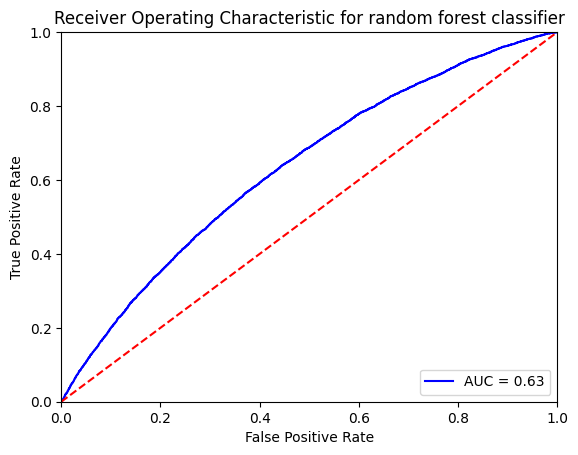

In [15]:
fpr_RF, tpr_RF, threshold_RF = metrics.roc_curve(y_test, y_pred_prob_RF)
roc_auc = metrics.auc(fpr_RF, tpr_RF)

#### Plot Roc Curve
plt.title('Receiver Operating Characteristic for random forest classifier')
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Extra trees classifier

In [16]:
model2 = Pipeline([
        ('sampling', SMOTE()),
        ('mdl2', ExtraTreesClassifier())
    ])

params2 = dict(mdl2__n_estimators = [100,500],
              mdl2__max_depth=[2, 6, 10],
              mdl2__min_samples_split=[2, 3, 4],
              mdl2__max_features=['sqrt', 'log2'],
            mdl2__bootstrap = [True])
    
def custom_metric(y_test, y_pred):
    _, fp, fn, _ = confusion_matrix(y_test, y_pred).ravel()
    score = 10*fn + fp
    return -score

custom_metric = make_scorer(custom_metric)
score = "roc_auc"

grid2 = GridSearchCV(model2, params2, cv=5, scoring=score, n_jobs=1, verbose=2)
grid2.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END mdl2__bootstrap=True, mdl2__max_depth=2, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=100; total time=  14.9s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=2, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=100; total time=  15.9s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=2, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=100; total time=  15.2s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=2, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=100; total time=  15.1s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=2, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=100; total time=  15.0s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=2, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=500; total time=  40.3s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=2, mdl2__max_features

[CV] END mdl2__bootstrap=True, mdl2__max_depth=2, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=500; total time=  33.9s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=2, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=500; total time=  34.0s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=2, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=500; total time=  33.8s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=6, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=100; total time=  23.6s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=6, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=100; total time=  24.3s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=6, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=100; total time=  24.9s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=6, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=100; tota

[CV] END mdl2__bootstrap=True, mdl2__max_depth=6, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=100; total time=  19.3s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=6, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=500; total time=  58.7s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=6, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=500; total time=  57.9s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=6, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=500; total time=  59.2s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=6, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=500; total time=  58.8s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=6, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=500; total time=  57.8s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=10, mdl2__max_features=sqrt, mdl2__min_samples_split=2, mdl2__n_estimators=100; tot

[CV] END mdl2__bootstrap=True, mdl2__max_depth=10, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=100; total time=  25.3s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=10, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=100; total time=  24.8s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=10, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=100; total time=  25.3s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=10, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=100; total time=  24.8s
[CV] END mdl2__bootstrap=True, mdl2__max_depth=10, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=500; total time= 1.5min
[CV] END mdl2__bootstrap=True, mdl2__max_depth=10, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=500; total time= 1.5min
[CV] END mdl2__bootstrap=True, mdl2__max_depth=10, mdl2__max_features=log2, mdl2__min_samples_split=4, mdl2__n_estimators=50

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('mdl2', ExtraTreesClassifier())]),
             n_jobs=1,
             param_grid={'mdl2__bootstrap': [True],
                         'mdl2__max_depth': [2, 6, 10],
                         'mdl2__max_features': ['sqrt', 'log2'],
                         'mdl2__min_samples_split': [2, 3, 4],
                         'mdl2__n_estimators': [100, 500]},
             scoring='roc_auc', verbose=2)

In [17]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement Extratrees Classifier:")
print(grid2.best_params_)
print("\n")
print("ROC AUC : {}".format(grid2.best_score_))

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement Extratrees Classifier:
{'mdl2__bootstrap': True, 'mdl2__max_depth': 10, 'mdl2__max_features': 'sqrt', 'mdl2__min_samples_split': 4, 'mdl2__n_estimators': 500}


ROC AUC : 0.6130346884520901


In [18]:
y_pred_prob2 = grid2.predict_proba(x_test)[:, 1]

def custom_metric(y_test, y_pred):
    _, fp, fn, _ = confusion_matrix(y_test, y_pred).ravel()
    score = 10*fn + fp
    return -score

best_thresh_EXT = None
best_custom_score_EXT = -np.inf
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_test, y_pred_prob2>thresh)
    if custom_score > best_custom_score_EXT:
        print(thresh)
        best_thresh_EXT = thresh
        best_custom_score_EXT = custom_score

 15%|████████████▏                                                                    | 15/100 [00:00<00:00, 146.27it/s]

0.0
0.06060606060606061
0.07070707070707072
0.08080808080808081
0.09090909090909091
0.10101010101010102
0.11111111111111112
0.12121212121212122
0.13131313131313133
0.14141414141414144
0.15151515151515152
0.16161616161616163
0.17171717171717174
0.18181818181818182
0.19191919191919193
0.20202020202020204
0.21212121212121213
0.22222222222222224
0.23232323232323235
0.24242424242424243
0.25252525252525254
0.26262626262626265
0.27272727272727276


 44%|███████████████████████████████████▋                                             | 44/100 [00:00<00:00, 131.79it/s]

0.2828282828282829
0.29292929292929293
0.30303030303030304
0.31313131313131315
0.32323232323232326


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 142.65it/s]


In [19]:
best_thresh_EXT

0.32323232323232326

In [20]:
best_custom_score_EXT

-54621

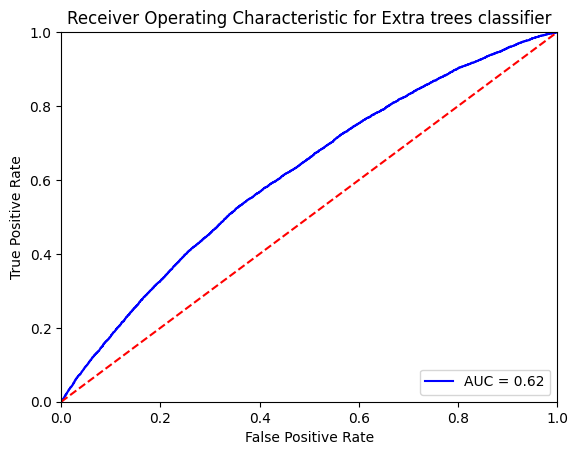

In [21]:
fpr_EXT, tpr_EXT, threshold_EXT = metrics.roc_curve(y_test, y_pred_prob2)
roc_auc = metrics.auc(fpr_EXT, tpr_EXT)

#### Plot Roc Curve
plt.title('Receiver Operating Characteristic for Extra trees classifier')
plt.plot(fpr_EXT, tpr_EXT, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Enregistrement du fichier au format pickle 

In [22]:
# modèle 
pickle.dump(grid, open('/mnt/c/Users/hager/OneDrive/Documents/projet_7/Openclassrooms_p7/final_prediction', 'wb'))

# best_thresh
pickle.dump(best_thresh_RF, open('/mnt/c/Users/hager/OneDrive/Documents/projet_7/Openclassrooms_p7/best_thresh', 'wb'))

test = pd.read_pickle("/mnt/c/Users/hager/OneDrive/Documents/projet_7/Openclassrooms_p7/X_test")
ID = pd.DataFrame(test["SK_ID_CURR"].values)

y_true_data = pd.DataFrame(y_pred_prob2, columns = {0 : "thresh" })
y_true_data = y_true_data.rename(columns={0: 'thresh'})
print(y_true_data.shape)

ID = pd.DataFrame(test["SK_ID_CURR"].values)
data_thresh = pd.concat([y_true_data,ID], axis = 1)
data_thresh = data_thresh.rename(columns={0: 'SK_ID_CURR'})

pickle.dump(data_thresh,open("/mnt/c/Users/hager/OneDrive/Documents/projet_7/Openclassrooms_p7/data_thresh", "wb"))

(76877, 1)


# Shap : features importances

## Features importances globals

In [68]:
x_train = x_train.drop(['Unnamed: 0'], axis = 1)

In [69]:
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(x_train, y_train)

RandomForestClassifier()

In [73]:
 #get the features importances
feat_importances = pd.Series(model.feature_importances_, index = x_train.columns).sort_values(ascending = True)

In [74]:
feat_importances[10:]

ORGANIZATION_TYPE_Trade: type 4       0.000016
ORGANIZATION_TYPE_Industry: type 8    0.000025
FLAG_DOCUMENT_17                      0.000030
FLAG_DOCUMENT_7                       0.000045
ORGANIZATION_TYPE_Religion            0.000050
                                        ...   
PAYMENT_RATE                          0.042413
DAYS_REGISTRATION                     0.044034
DAYS_ID_PUBLISH                       0.044425
DAYS_BIRTH                            0.045500
EXT_SOURCE_2                          0.063086
Length: 181, dtype: float64

<AxesSubplot: >

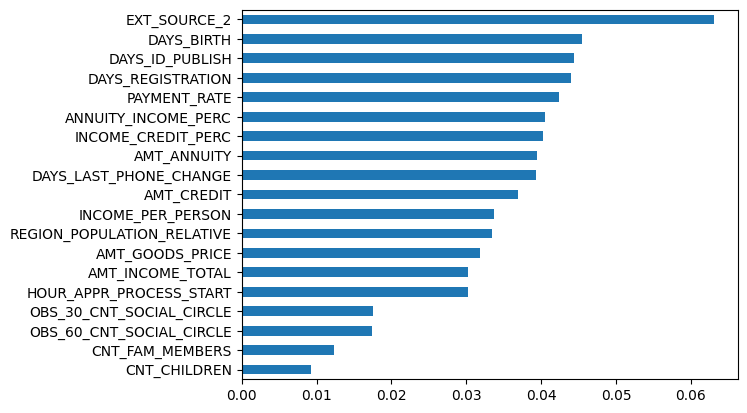

In [75]:
feat_importances[172:].plot(kind = 'barh')

In [76]:
pickle.dump(feat_importances,open("/mnt/c/Users/hager/OneDrive/Documents/projet_7/Openclassrooms_p7/feat_importances", "wb"))

In [80]:
features_importance = pickle.load(open("/mnt/c/Users/hager/OneDrive/Documents/projet_7/Openclassrooms_p7/feat_importances", 'rb'))